50%用户在4年之内就卖车
50%用户在5miles 就卖车，90%开了12 miles 卖车

白色车用户爱卖车
自动挡用户爱卖车

自动挡用户3.5年卖车，手动6.5年卖车
	
top 5 白,灰，黑，银，红  （灰=银）

## Step1: load package and merge dataset

In [1]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_columns', 500)   # print all info in cell
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_colwidth', -1)  # print all info in cell

In [2]:
# display chinese
import matplotlib.font_manager as mfm
import matplotlib.pyplot as plt
font_path = "/Users/wyywenyi/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf"
prop = mfm.FontProperties(fname=font_path)

In [101]:
df_2016_2019 = pd.read_excel('丰田卡罗拉-20190328.xlsx', sheet_name = '2016-2019', encoding='utf-8' )
df_2013_2015 = pd.read_excel('丰田卡罗拉-20190328.xlsx', sheet_name = '2013-2015', encoding='utf-8')
df_2010_2012 = pd.read_excel('丰田卡罗拉-20190328.xlsx', sheet_name = '2010-2012', encoding='utf-8' )
df_2006_2009 = pd.read_excel('丰田卡罗拉-20190328.xlsx', sheet_name = u'2009以前',  encoding='utf-8' )

In [277]:
df = df_2016_2019.append(df_2013_2015).copy()
df = df.append(df_2010_2012).copy()
df = df.append(df_2006_2009).copy()

In [279]:
columns_names = {u'ID':'id',u'城市':'city',u'车型':'auto_full_name',u'车款年份':'model_year',\
                 u'来源':'source',u'发布日期':'publish_date',u'下线日期':'sale_date',\
                 u'周转天数':'date_on_market',u'最后成交价':'final_price',u'初次报价':'original_price',\
                 u'颜色':'color',u'里程':'miles',u'档位':'manual_or_automated',u'上牌日期':'plate_date',u'上牌年':'plate_year'}

df.rename(index=str, columns = columns_names,inplace = True)
df.info()

## Step2: Split auto full_name and output dataset

In [105]:
# 丰田 卡罗拉 2017款 改款 1.2T CVT GLX;   #西安 莲湖区-卡罗拉 2016款 1.6L CVT GL-i炫酷版
# 丰田：make
# 卡罗拉：model_name
# 改款: if_update
# 1.2T: liter
# CVT: transmission_type
# GLX: trim_1
# GL-i炫酷版: trim_1


# 丰田:    u'\u4e30\u7530'
# 卡罗拉:  u'\u5361\u7f57\u62c9'


import sys
reload(sys)
sys.setdefaultencoding("utf-8")


# create a dic of dic
full_name_feature = {}

for row in range(0,len(df)):
    full_name = df.iloc[row,2]   # '卡罗拉 西安 莲湖区-卡罗拉 2016款 1.6L CVT GL-i炫酷版'
    full_name = full_name.replace('-','|').replace('—','|').replace(' ','|').split('|')  # remove whitespace and convert into list
    
    feature = {}
    
    for i in full_name:
        i = i.strip()              #remove white space
        print i
        if i == u'丰田':
            feature['make'] = i
       
        elif i == u'卡罗拉':
            feature['model_name'] = i
        
        elif (('L' in i) and (i[0].isdigit())) or (('T' in i) and (i[0].isdigit())):   #1.6L, 1.2T
            feature['liter'] = i
     
        elif u'改' in i:                   # 改款
            feature['if_update'] = i
                            
        elif u'CV' in i:                   # CVT
            feature['if_CVT'] = i
            
        elif u'GL' in i:                   # GL
            feature['if_GL'] = i
        
        elif u'款' in i:                   # 改款
            feature['trim_1'] = i   
     
        elif u'版' in i and  u'皮' not in i  :    # 智尚版
            feature['trim_2'] = i 
            
        elif u'双擎' in i:                        # 双擎
            feature['if_hybrid'] = i 
            
        elif u'皮' in i:                         # 真皮版
            feature['internal_material'] = i  
        
        else:
            continue
        
        
    full_name_feature[row] = feature

In [178]:
df_output = pd.DataFrame(full_name_feature).T
df_output = df_output.add_prefix('att_')

In [281]:
df_output.to_csv('att_full_name.csv',encoding = 'utf-8')
df.to_csv('corolla_2006_2019.csv',encoding = 'utf-8')

## Step 3: import, clean, output dataset

In [320]:
import pandas as pd
pd.set_option('display.max_columns', 500)   # print all info in cell
pd.set_option('display.max_colwidth', -1)  # print all info in cell

df_output = pd.read_csv('att_full_name.csv', encoding = 'utf-8')
df_corolla = pd.read_csv('corolla_2006_2019.csv', encoding = 'utf-8')

In [321]:
df = df_output.merge(df_corolla,left_index = True, right_index = True, how = 'inner')
df.drop(columns = [u'Unnamed: 0_x',u'Unnamed: 0_y'],inplace = True)

In [323]:
## clean datetime column

df = df[df.plate_date.str[0] == '2'].copy()                     # choose plate_year >= year 2000
df.plate_date = pd.to_datetime(df.plate_date).copy()            # choose plate_date  convert into datatime

df.publish_date = pd.to_datetime(df.publish_date).copy()        # choose sale_date  convert into datatime
df.sale_date = pd.to_datetime(df.sale_date).copy()              # choose publish_date convert into datatime

In [325]:
## compute atuo age

import numpy as np
df['age_month'] = (df.publish_date - df.plate_date)/np.timedelta64(1, 'M')
df['age_month'] = df.age_month.astype('int')

In [326]:
## compute price_adjustment

df['price_adj'] = df.original_price - df.final_price 
df['price_adj'] = df.price_adj.fillna(0)

In [327]:
## reset auto name

df['att_make'] = 'Toyota'
df['att_model_name'] = 'Corolla'

In [329]:
## remove meaningless row: '同车系推荐丰田卡罗拉'  (must contains 1.2T, 1.6L )

df = df[df.auto_full_name.str.contains('L') | df.auto_full_name.str.contains('T')]

In [331]:
## drop duplicated row， subset
## 所有的duplicate 都是出现在平台上 ‘146684136， 平台车源，商户车源’

subset_column = list(df.columns)
subset_column.remove('source') 

df.drop_duplicates(keep = 'first',subset = subset_column, inplace = True)

In [333]:
df.to_csv('corolla_2006_2019_v2.csv',encoding = 'utf-8')

## Step 4: EDA

In [189]:
import pandas as pd
pd.set_option('display.max_columns', 500)   # print all info in cell
pd.set_option('display.max_colwidth', -1)  # print all info in cell

df = pd.read_csv('corolla_2006_2019_v2.csv',low_memory = False)

sales = pd.read_excel('corolla_new_car_sales.xlsx' ,encoding = 'utf-8')

In [190]:
df.columns

Index([u'Unnamed: 0', u'att_if_CVT_x', u'att_if_GL_x', u'att_if_hybrid_x',
       u'att_if_update_x', u'att_internal_material_x', u'att_liter_x',
       u'att_make_x', u'att_model_name_x', u'att_trim_1_x', u'att_trim_2_x',
       u'Unnamed: 0.1', u'att_if_CVT_y', u'att_if_GL_y', u'att_if_hybrid_y',
       u'att_if_update_y', u'att_internal_material_y', u'att_liter_y',
       u'att_make_y', u'att_model_name_y', u'att_trim_1_y', u'att_trim_2_y',
       u'id', u'city', u'auto_full_name', u'model_year', u'source',
       u'publish_date', u'sale_date', u'date_on_market', u'final_price',
       u'original_price', u'color', u'miles', u'manual_or_automated',
       u'plate_date', u'plate_year', u'age_month', u'price_adj', u'age_year',
       u'att_make', u'att_model_name'],
      dtype='object')

### Q0 dataset distribution

In [191]:
%matplotlib inline
from matplotlib import pyplot as plt
len(df)

179585

In [192]:
df.describe(include = 'all')

,Unnamed: 0,att_if_CVT_x,att_if_GL_x,att_if_hybrid_x,att_if_update_x,att_internal_material_x,att_liter_x,att_make_x,att_model_name_x,att_trim_1_x,att_trim_2_x,Unnamed: 0.1,att_if_CVT_y,att_if_GL_y,att_if_hybrid_y,att_if_update_y,att_internal_material_y,att_liter_y,att_make_y,att_model_name_y,att_trim_1_y,att_trim_2_y,id,city,auto_full_name,model_year,source,publish_date,sale_date,date_on_market,final_price,original_price,color,miles,manual_or_automated,plate_date,plate_year,age_month,price_adj,age_year,att_make,att_model_name
count,179585.000000,77833,165181,5662,9150,6344,134155,100088,169348,173354,41712,179585.000000,73830,168774,5210,8587,5917,129381,179585,179585,173500,41893,1.795850e+05,179585,179585,179585.000000,179585,179585,179585,179585.000000,179585.000000,151188.000000,159365,177901.000000,178211,179585,179585.000000,179585.000000,179585.000000,179585.000000,179585,179585
unique,NaN,99,2823,5,21,65,107,1,1,202,722,NaN,99,3175,3,22,70,104,1,1,173,713,NaN,723,18785,NaN,3,178262,176964,NaN,NaN,NaN,14,NaN,6,215,NaN,NaN,NaN,NaN,1,1
top,NaN,CVT,GL,双擎,改款,i真皮版,1.6L,丰田,卡罗拉,2014款,特装版,NaN,CVT,GL,双擎,改款,i真皮版,1.6L,Toyota,Corolla,2014款,特装版,NaN,东莞,丰田 卡罗拉 2014款 1.6L CVT GL,NaN,商户车源,2018-09-03 20:29:51,2018-09-15 17:26:51,NaN,NaN,NaN,白,NaN,自动,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,Toyota,Corolla
freq,NaN,67872,76259,5494,5611,4306,89329,100088,169348,54451,10230,NaN,64450,76260,5208,5250,3913,85679,179585,179585,52382,9607,NaN,11616,8811,NaN,148563,7,5,NaN,NaN,NaN,69771,NaN,141185,3231,NaN,NaN,NaN,NaN,179585,179585
mean,89792.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95204.486416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.748623e+08,NaN,NaN,1965.541855,NaN,NaN,NaN,18.054136,8.058646,8.038311,NaN,5.600134,NaN,NaN,2013.039424,53.390250,0.007120,3.988624,NaN,NaN
std,51841.868384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55329.205606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.317616e+07,NaN,NaN,303.921254,NaN,NaN,NaN,21.678933,3.713935,3.027042,NaN,3.728272,NaN,NaN,2.971052,33.653185,0.177082,2.816732,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.227702e+07,NaN,NaN,0.000000,NaN,NaN,NaN,-15.000000,0.600000,0.680000,NaN,0.000000,NaN,NaN,2000.000000,-77.000000,-22.600000,-6.000000,NaN,NaN
25%,44896.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47726.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.463557e+08,NaN,NaN,2011.000000,NaN,NaN,NaN,3.000000,6.380000,6.390000,NaN,2.800000,NaN,NaN,2011.000000,25.000000,0.000000,2.000000,NaN,NaN
50%,89792.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94965.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.799029e+08,NaN,NaN,2013.000000,NaN,NaN,NaN,14.000000,8.180000,8.170000,NaN,5.000000,NaN,NaN,2014.000000,47.000000,0.000000,3.000000,NaN,NaN
75%,134688.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142888.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.044787e+08,NaN,NaN,2014.000000,NaN,NaN,NaN,26.000000,9.600000,9.580000,NaN,8.000000,NaN,NaN,2016.000000,79.000000,0.000000,6.000000,NaN,NaN


### Q1 auto age distribution

In [193]:
df.age_month.describe()

count    179585.000000
mean     53.390250    
std      33.653185    
min     -77.000000    
25%      25.000000    
50%      47.000000    
75%      79.000000    
max      196.000000   
Name: age_month, dtype: float64

In [194]:
age_month = df.age_month[df.age_month >= 0]

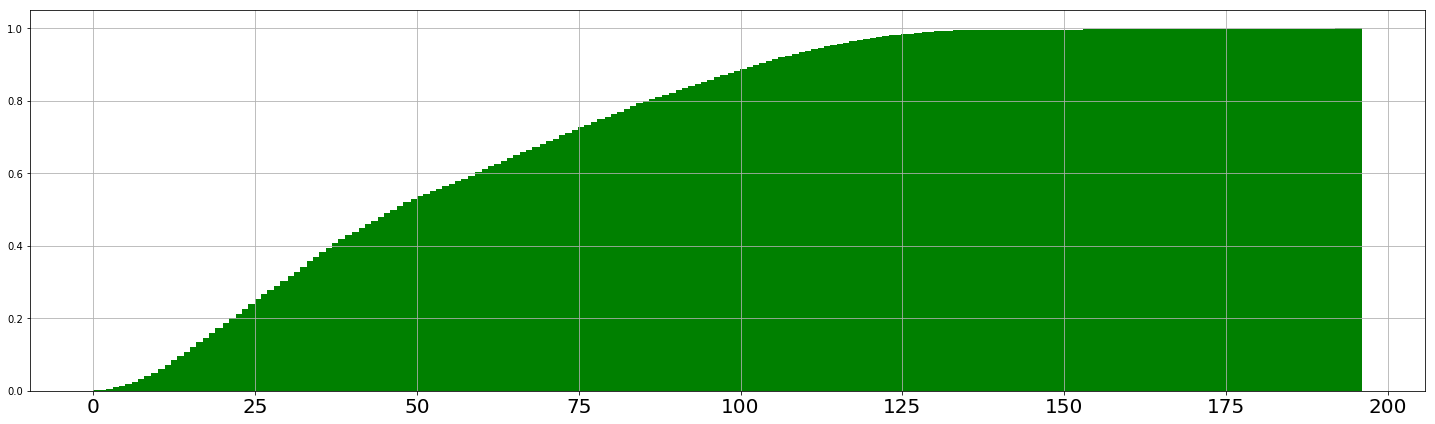

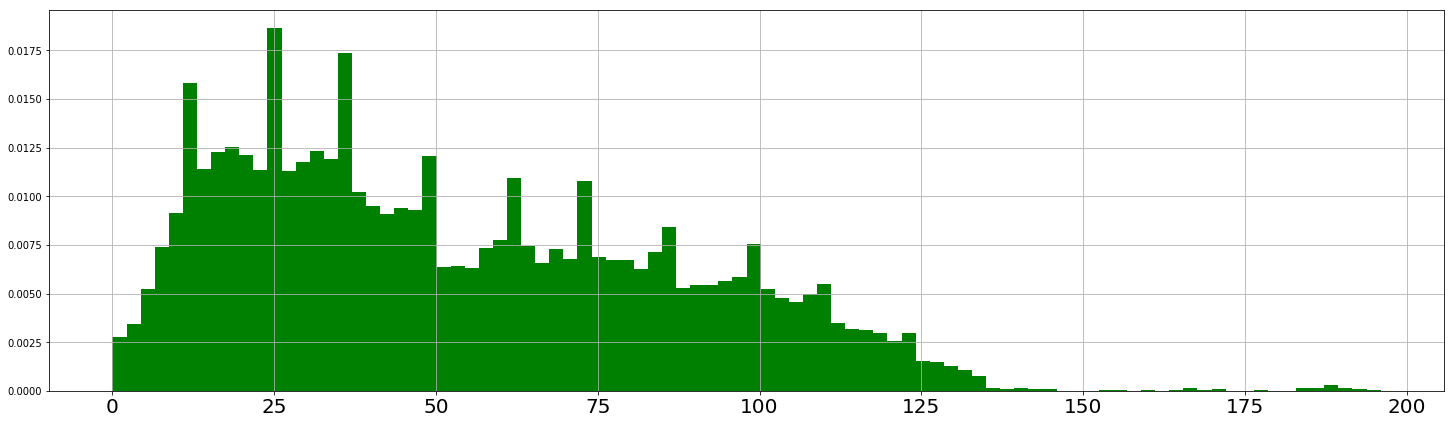

In [195]:
print '***********'
print '*** AGE ***'
print '***********'
print ''

print '*********** CDF distribution (x-axis:Month,y-axis:Percentage) ***********'
print '(1)1-4 YEARS 0 -48 Month: grow rate is fast'
print '(2)4-7 YEARS 48-84 Month: grow rate is normal'
print '(2)7+YEARS 84+   Month: grow rate is slow'


age_month.hist(cumulative=True, density = 1, bins=1000, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'green')
plt.show()

print '***********  PDF distribution (x-axis:Month,y-axis:Percentage) *********** '
age_month.hist(cumulative=False, density=1, bins=90, figsize=(25, 7),grid = True, xlabelsize= 20,color =  'green')
plt.show()

In [196]:
#age_month.value_counts(normalize=True).sort_index(ascending = True)

### Q2 mile distribution

In [197]:
df.miles.describe()

count    177901.000000
mean     5.600134     
std      3.728272     
min      0.000000     
25%      2.800000     
50%      5.000000     
75%      8.000000     
max      194.000000   
Name: miles, dtype: float64

In [198]:
miles = df.miles[df.miles <= 25]

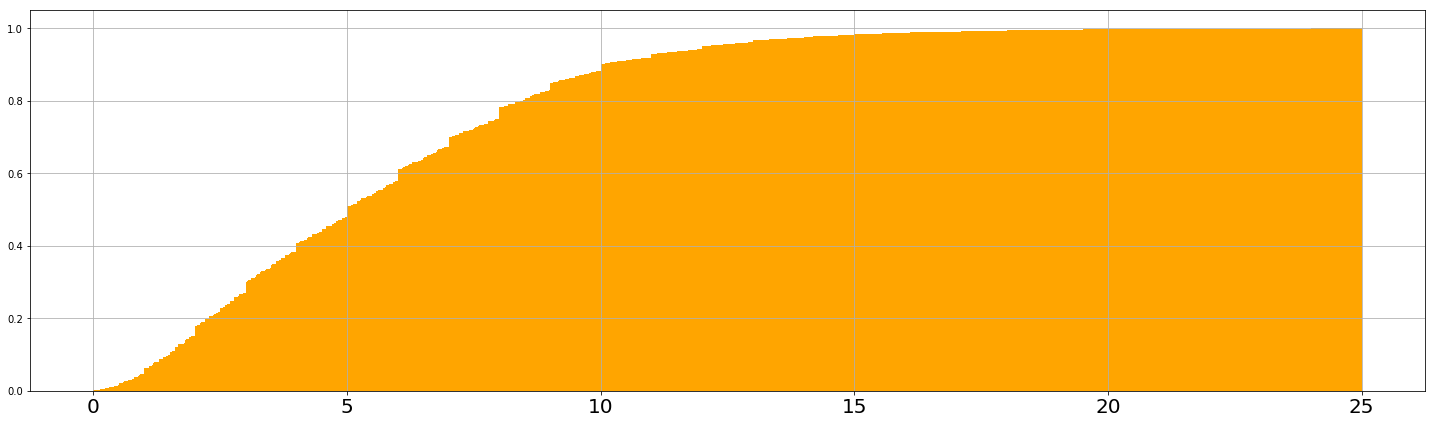

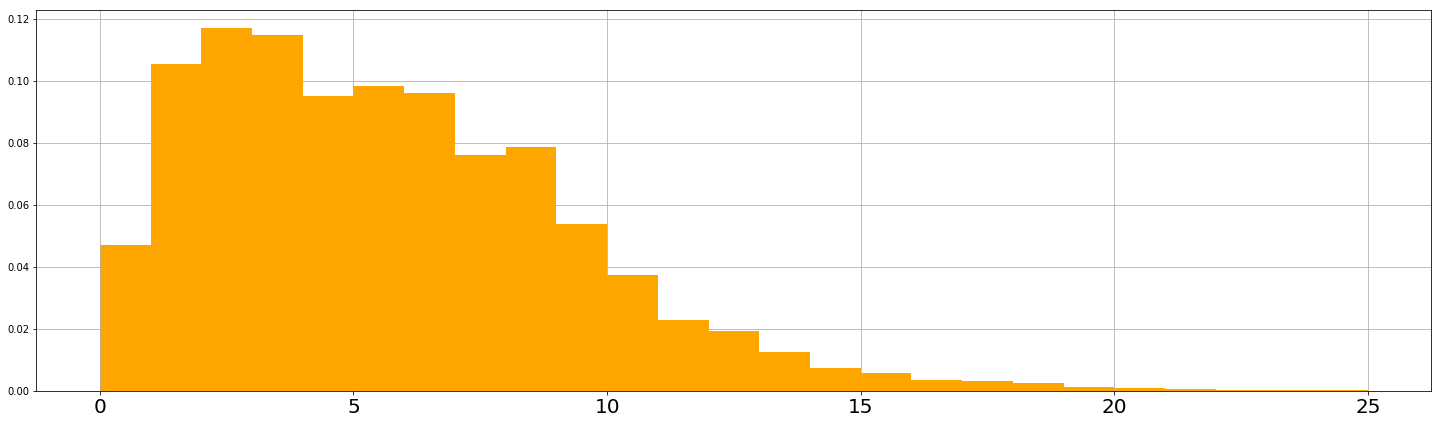

In [199]:
print '***********'
print '*** MILES ***'
print '***********'
print ''

print '*********** CDF distribution (x-axis:Miles,y-axis:Percentage) ***********'
miles.hist(cumulative=True, density = 1, bins=1000, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'orange')
plt.show()

print '*********** PDF distribution (x-axis:Miles,y-axis:Percentage) ***********'
miles.hist(cumulative=False, density=1, bins=25, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'orange')
plt.show()

### Q3 model year

In [200]:
df.model_year.describe()

count    179585.000000
mean     1965.541855  
std      303.921254   
min      0.000000     
25%      2011.000000  
50%      2013.000000  
75%      2014.000000  
max      2019.000000  
Name: model_year, dtype: float64

In [201]:
model_year = df.model_year[df.model_year > 0]

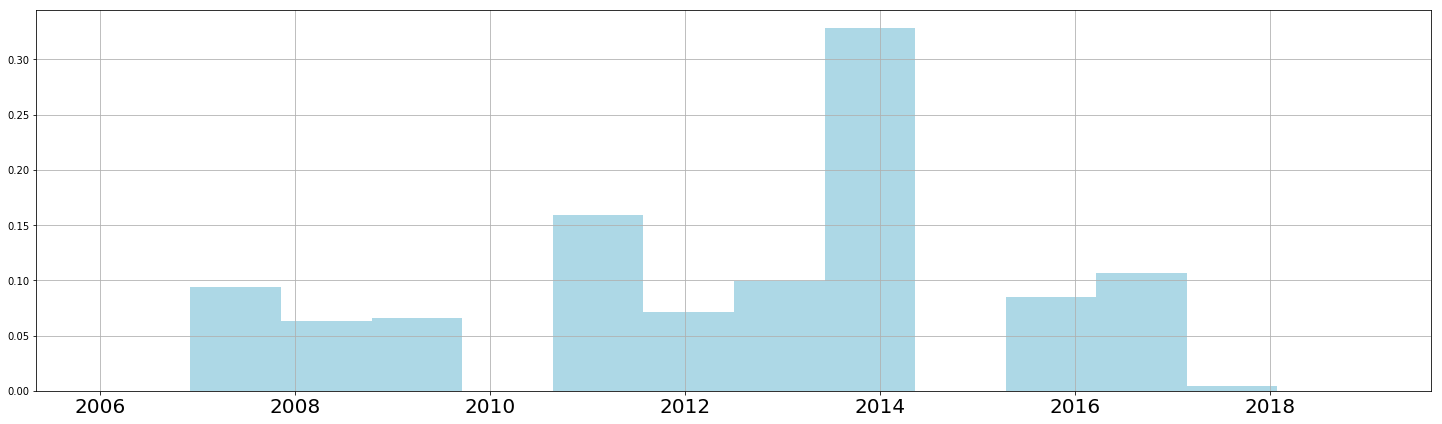

In [202]:
print '*******************'
print '*** Model  Year ***'
print '*******************'
print ''

print '*********** PDF distribution (x-axis:Year,y-axis:Percentage) ***********'
print '(1) Model year 2014 >=30%'
model_year.hist(cumulative=False, density=1, bins=14, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'lightblue')
plt.show()

In [203]:
model_year.value_counts(normalize=True).sort_index(ascending = False)

2019    0.000034
2018    0.004054
2017    0.098750
2016    0.078453
2015    0.000040
2014    0.304621
2013    0.092479
2012    0.066206
2011    0.148160
2010    0.000097
2009    0.061217
2008    0.058503
2007    0.087359
2006    0.000029
Name: model_year, dtype: float64

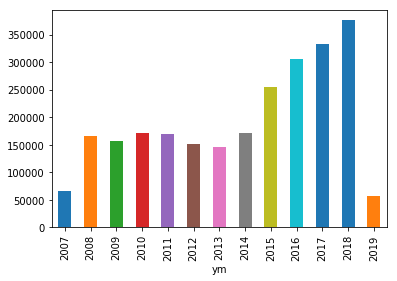

In [204]:
sales.groupby(sales.ym.dt.year).sales.sum().plot(kind = 'bar') 
plt.show()

In [205]:
new_sale = sales.groupby(sales.ym.dt.year).sales.sum() 
old_sale = model_year.value_counts()
pd.concat([old_sale,new_sale,old_sale/new_sale ],axis = 1)

,model_year,sales,0
2006,5,NaN,NaN
2007,15322,65844.0,0.232702
2008,10261,165270.0,0.062086
2009,10737,157457.0,0.068190
2010,17,172053.0,0.000099
2011,25986,170117.0,0.152754
2012,11612,151887.0,0.076452
2013,16220,146480.0,0.110732
2014,53428,171486.0,0.311559
2015,7,254301.0,0.000028


## Q4 周转天数

In [206]:
df.date_on_market.describe()

count    179585.000000
mean     18.054136    
std      21.678933    
min     -15.000000    
25%      3.000000     
50%      14.000000    
75%      26.000000    
max      4828.000000  
Name: date_on_market, dtype: float64

In [207]:
date_on_market = df.date_on_market[(df.date_on_market >= 0) & (df.date_on_market <= 120)]

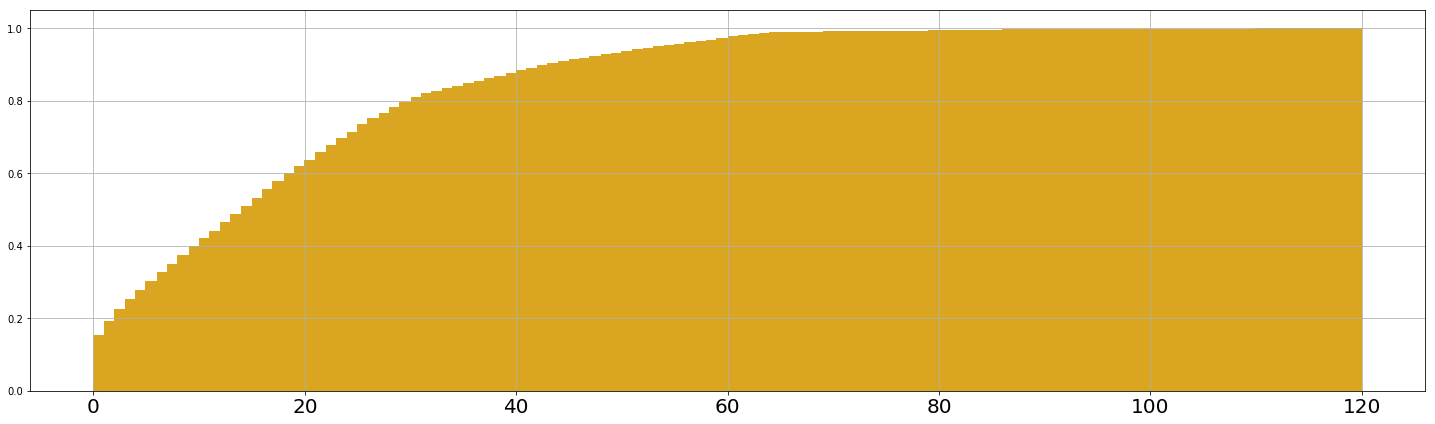

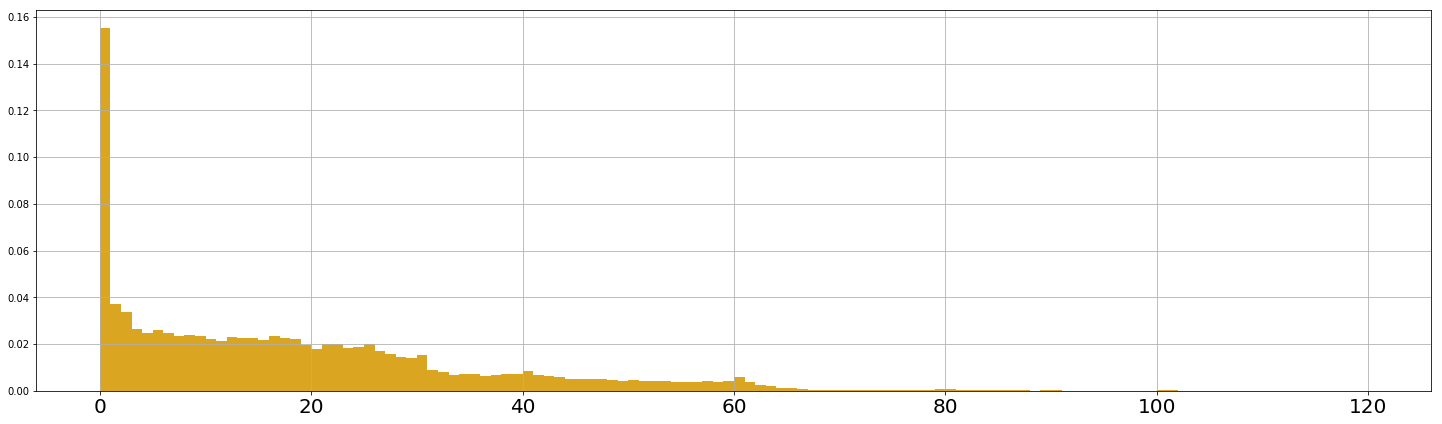

In [208]:
print '**********************'
print '*** days_on_market ***'
print '**********************'
print ''

print '*********** CDF distribution (x-axis:Year,y-axis:Percentage) ***********'
print '(1) 0-30days >=80%'

date_on_market.hist(cumulative=True, density=1, bins=1000, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'goldenrod')
plt.show()

print '*********** PDF distribution (x-axis:Year,y-axis:Percentage) ***********'
print '(1) 1 day  = 16%'
print '(2) 2 days = 4%'
print '(3) 3 days = 3%'
date_on_market.hist(cumulative=False, density=1, bins=120, figsize=(25, 7),grid = True, xlabelsize= 20,color = 'goldenrod')
plt.show()

## Q5 source

In [209]:
df.source.value_counts(normalize=True)

商户车源    0.827257
平台车源    0.138814
个人车源    0.033928
Name: source, dtype: float64

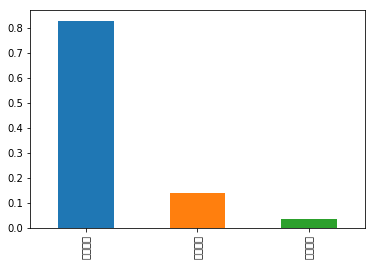

In [210]:
df.source.value_counts(normalize=True).plot(kind = 'bar')
plt.show()

## Q6 车龄和售价的关系

In [211]:
df.final_price.describe()

count    179585.000000
mean     8.058646     
std      3.713935     
min      0.600000     
25%      6.380000     
50%      8.180000     
75%      9.600000     
max      963.000000   
Name: final_price, dtype: float64

In [212]:
df['age_year'] = (pd.to_datetime(df.publish_date) - pd.to_datetime(df.plate_date))/np.timedelta64(1, 'Y')
df['age_year'] = df.age_year.astype('int')

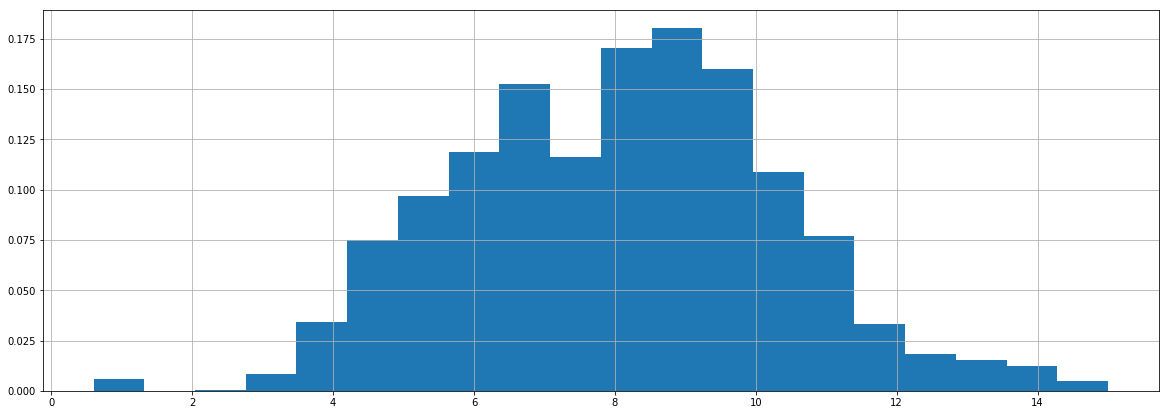

In [213]:
print '--- 成交价分布 ---' 
df.loc[(df.final_price <= 15.00),'final_price'].hist(density=1, bins=20,figsize = (20,7))
plt.show()

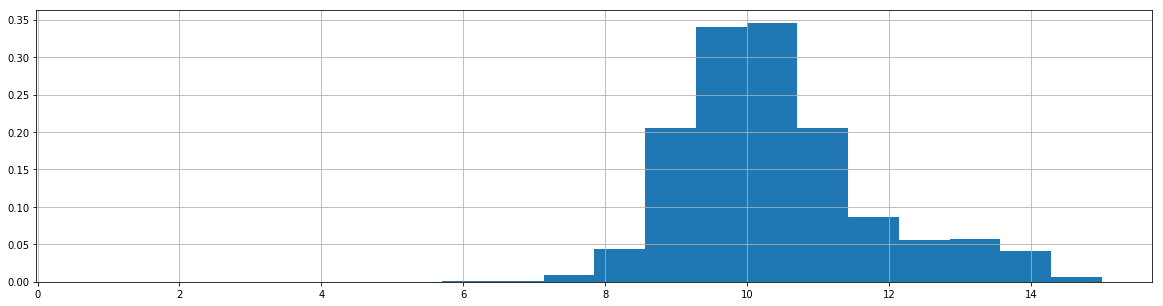

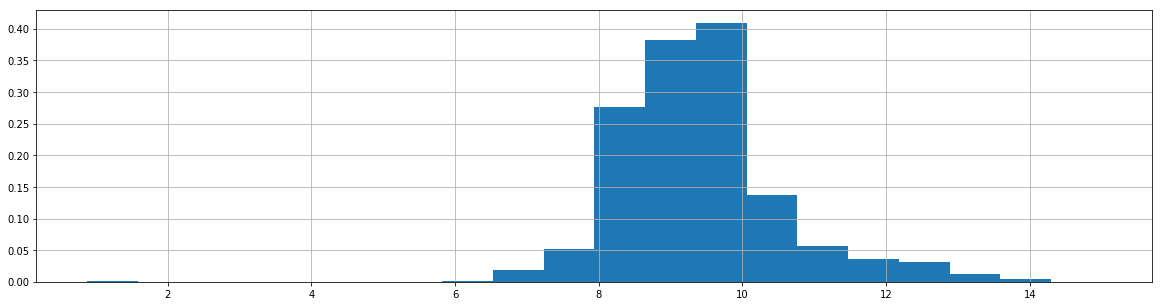

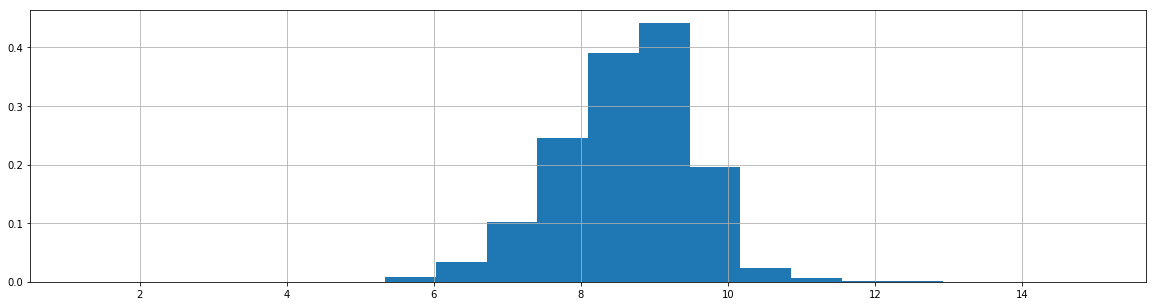

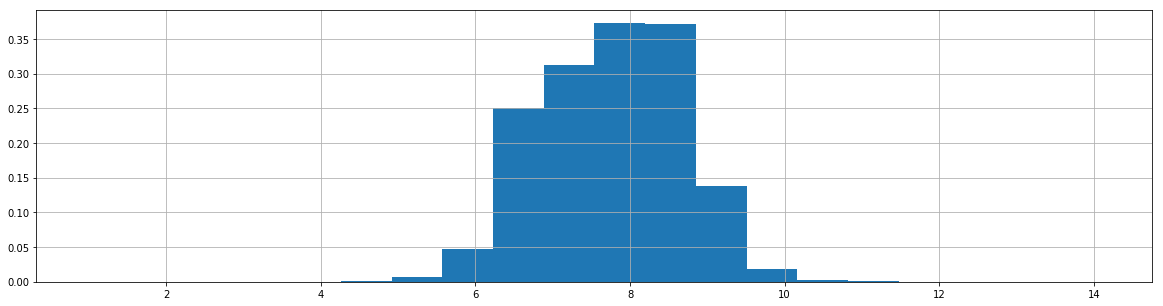

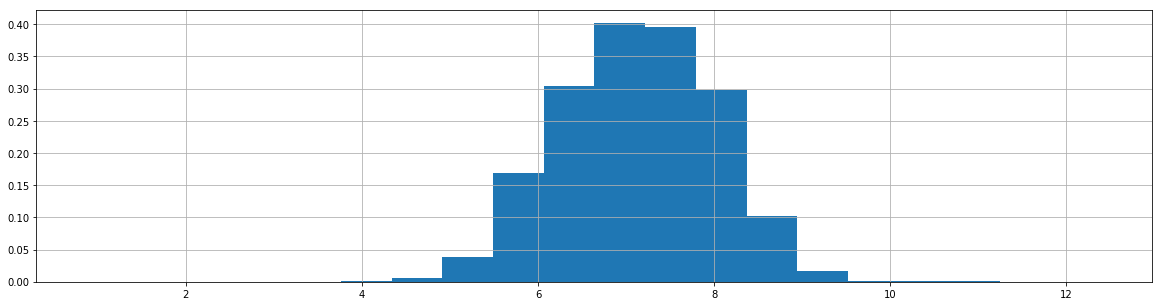

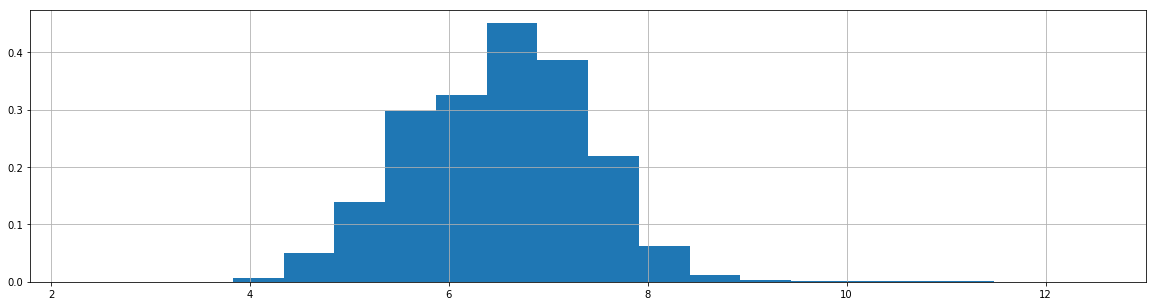

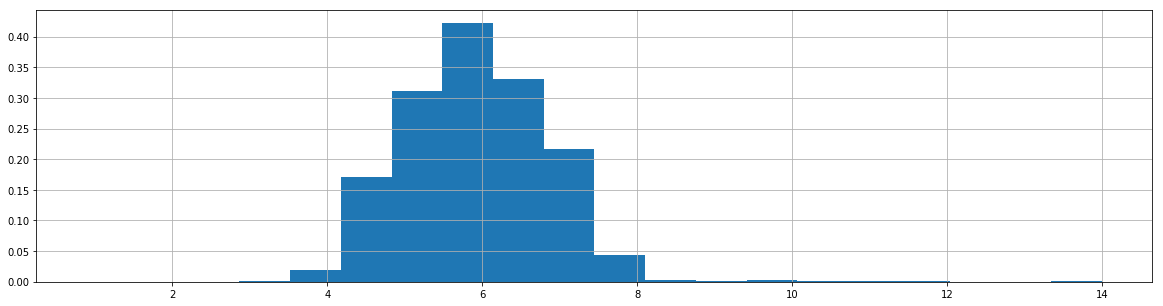

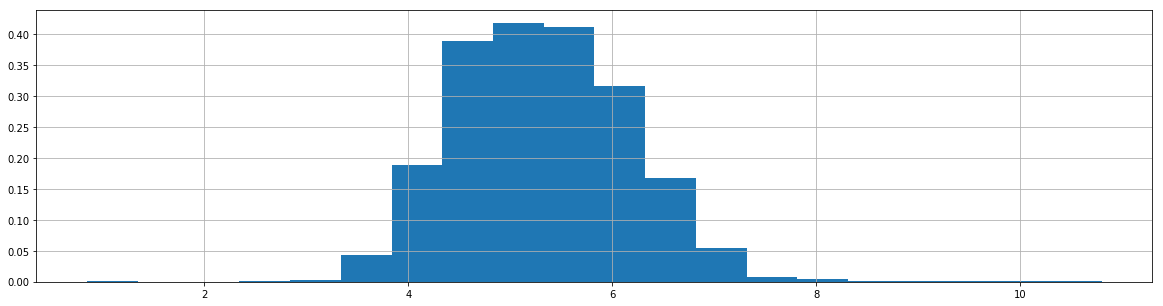

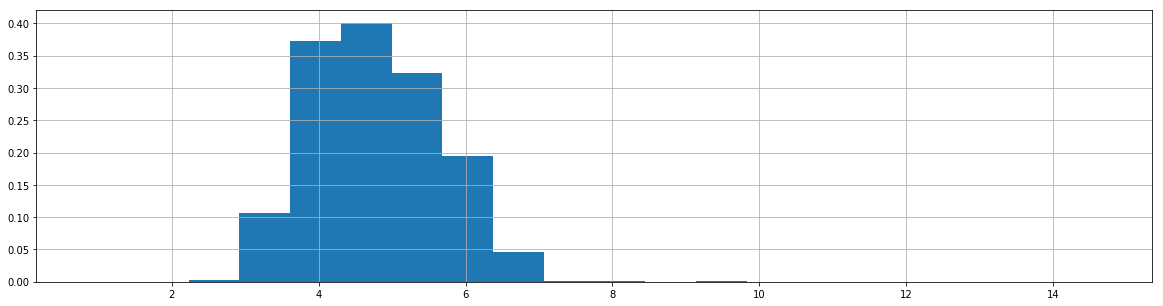

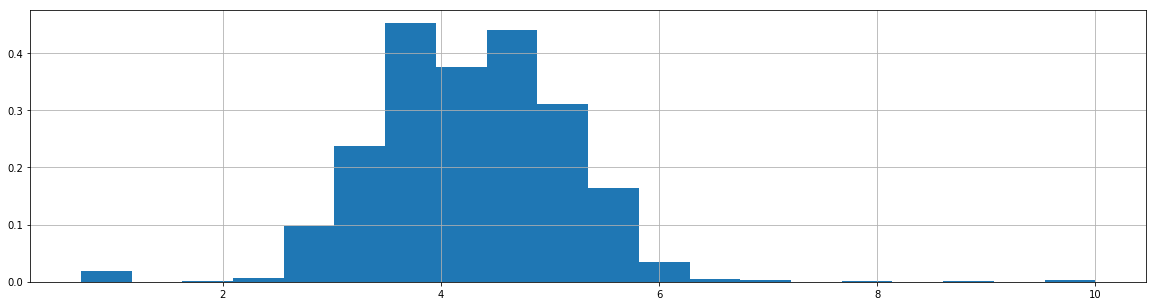

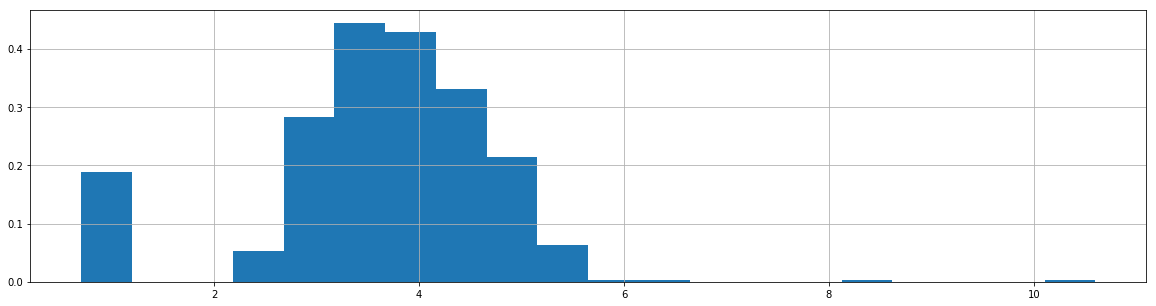

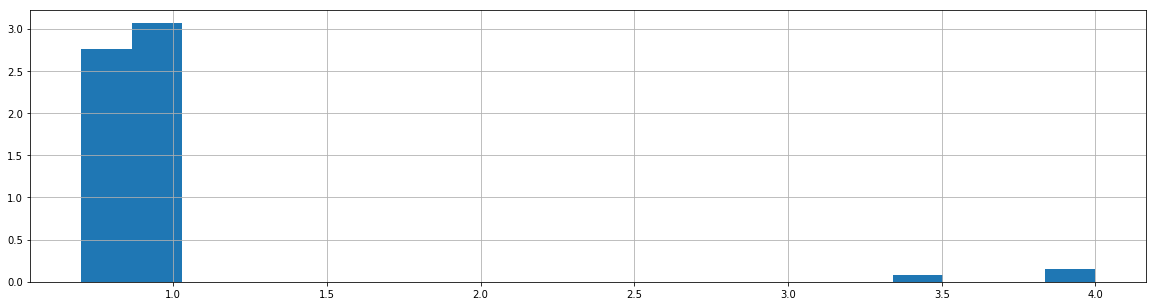

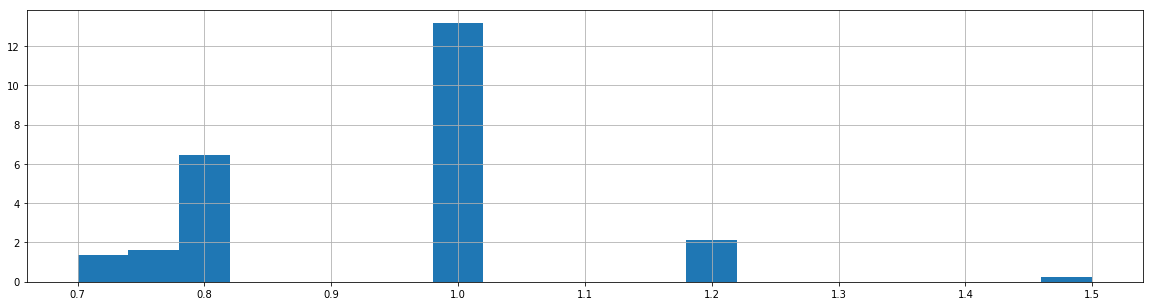

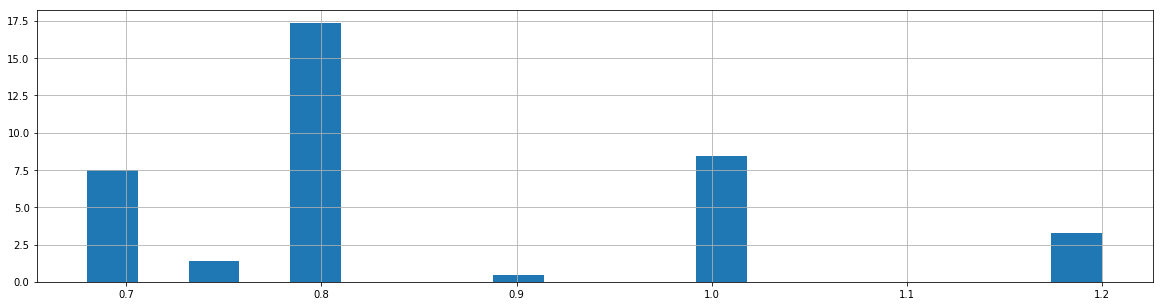

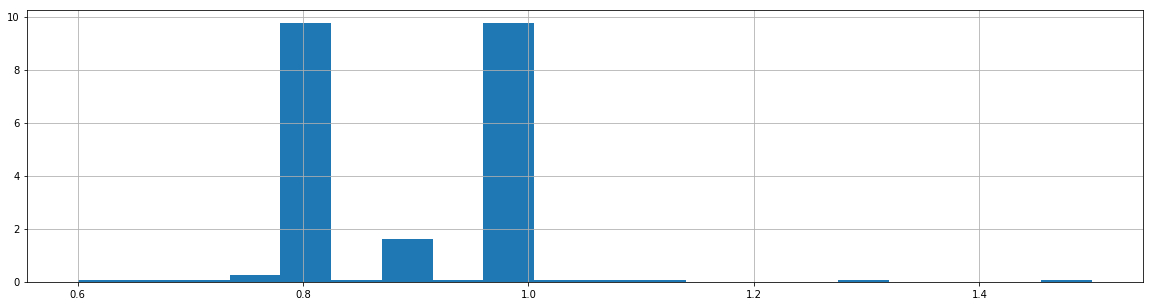

In [214]:
for i in range (1,16):
    print '车龄与成交价的关系--- 车龄 %s 年---' %(i) 
    df.loc[((df.age_year == i) & (df.final_price <= 15.00)),'final_price'].hist(density=1, bins=20,figsize = (20,5))
    plt.show()

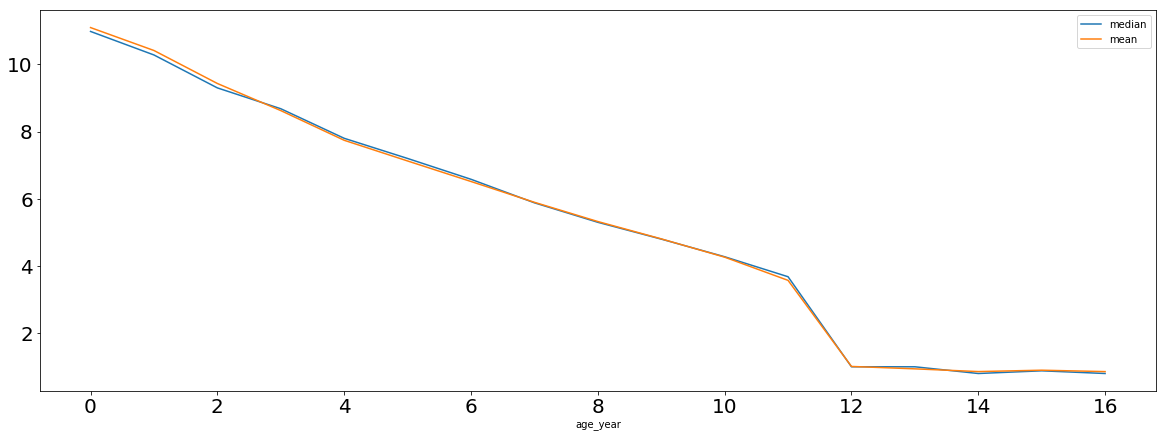

In [215]:
print '车龄与中位成交价的关系--- x-axis: 车龄(年)  y-axis:成交价(万)---'  

d1 = df[df.age_year >=0]
d1.groupby('age_year').final_price.agg(['median','mean',]).plot(kind='line', figsize = (20,7),fontsize = 20)
plt.show()

In [216]:
median_avg_price = d1.groupby('age_year').final_price.agg(['median','mean'])
median_avg_price

,median,mean
age_year,,
0,10.980,11.095189
1,10.280,10.412919
2,9.300,9.431338
3,8.680,8.624612
4,7.800,7.740903
5,7.200,7.125140
6,6.580,6.514240
7,5.880,5.895130
8,5.300,5.322696


In [217]:
# depreciation everyyear
year_0 = median_avg_price.loc[0,'median']
median_avg_price.loc[:,'median']  - year_0

age_year
0     0.000 
1    -0.700 
2    -1.680 
3    -2.300 
4    -3.180 
5    -3.780 
6    -4.400 
7    -5.100 
8    -5.680 
9    -6.180 
10   -6.705 
11   -7.300 
12   -9.980 
13   -9.980 
14   -10.180
15   -10.100
16   -10.180
Name: median, dtype: float64

## Q7 操控

In [218]:
df.manual_or_automated.value_counts(normalize=True)

自动            0.792235
手动            0.205711
手自一体          0.002009
8挡 CVT无级变速    0.000028
CVT无级变速       0.000011
5挡 手动         0.000006
Name: manual_or_automated, dtype: float64

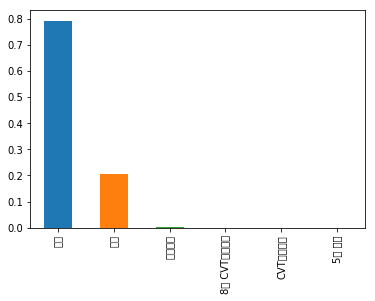

In [219]:
print '------ 手自动占比 ------'  
df.manual_or_automated.value_counts(normalize=True).plot(kind = 'bar')
plt.show()

In [220]:
df.groupby('manual_or_automated').age_month.agg(['count','max','min','median','mean'])

,count,max,min,median,mean
manual_or_automated,,,,,
5挡 手动,1,33,33,33,33.000000
8挡 CVT无级变速,5,31,1,8,13.000000
CVT无级变速,2,16,12,14,14.000000
手动,36660,196,-77,76,74.867540
手自一体,358,119,1,29,37.932961
自动,141185,196,0,40,48.137862


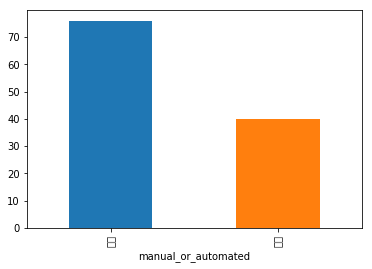

In [221]:
print '------ 车龄vs手自动 ------'  
d2 = df[(df.manual_or_automated == '自动' )|( df.manual_or_automated == '手动')]
df.manual_or_automated.unique()
d2.groupby('manual_or_automated').age_month.agg(['max','min','median','mean'])
d2.groupby('manual_or_automated').age_month.median().plot(kind = 'bar')
plt.show()
print ''

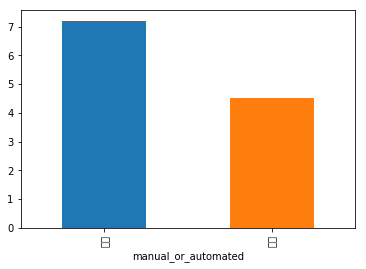

In [222]:
print '------ 行驶里程vs手自动 ------'  
d2.groupby('manual_or_automated').miles.median().plot(kind = 'bar')
plt.show()

In [223]:
d_color_count = df.color.value_counts()
d_color_mile = df.groupby('color').miles.median()
d_color_age = df.groupby('color').age_month.median()

In [224]:
d_col_count_age = pd.concat([d_color_count,d_color_age],axis = 1 ,join='inner')

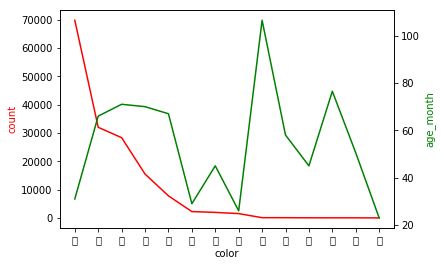

In [225]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(d_col_count_age.index, d_col_count_age.color, 'red')
ax2.plot(d_col_count_age.index, d_col_count_age.age_month, 'green')

ax1.set_xlabel('color')
ax1.set_ylabel('count', color='red')
ax2.set_ylabel('age_month', color='green')

plt.show()

In [226]:
d2.groupby(['color','manual_or_automated']).age_month.agg(['count','median']).unstack()

count          median       
manual_or_automated       手动       自动     手动     自动
color                                              
棕                    191.0    1758.0   52.0   43.0 
橙                    10.0     33.0     112.0  45.0 
灰                    7565.0   24231.0  84.0   59.0 
白                    8193.0   60398.0  58.0   29.0 
米                   NaN       3.0     NaN     23.0 
紫                    18.0     63.0     114.5  51.0 
红                    835.0    6892.0   85.0   66.0 
绿                    13.0     23.0     116.0  45.0 
蓝                    135.0    1388.0   105.0  24.0 
褐                    4.0      30.0     53.0   50.0 
金                    209.0    2000.0   93.0   27.5 
银                    4450.0   11015.0  81.0   64.0 
黄                    25.0     60.0     113.0  105.5
黑                    10062.0  18030.0  83.0   64.0

## Step 5: Final Clean and output

In [424]:
df = pd.read_csv('corolla_2006_2019_v2.csv',low_memory = False)
df_vf = df.copy()

In [425]:
# 将color的灰变成银色
df_vf.color.replace('灰','银',inplace = True)

# remove出%低的颜色
df_vf = df_vf[df_vf.color.isin(['白','银','黑','金','棕' ])]

In [426]:
# age_month >0
df_vf = df_vf[df_vf.age_month >= 0]

In [427]:
# miles <=25
df_vf = df_vf[df_vf.miles <= 25]

In [428]:
# model year > 0
df_vf = df_vf[df_vf.model_year > 0]

In [429]:
# add age_year
df_vf['age_year'] = (pd.to_datetime(df_vf.publish_date) - pd.to_datetime(df_vf.plate_date))/np.timedelta64(1, 'Y')
df_vf['age_year'] = df_vf.age_year.astype('int')

In [430]:
# add age_year < 15K
df_vf = df_vf[df_vf.final_price <= 15.00]

In [431]:
# choose 手动，自动
df_vf = df_vf[df_vf.manual_or_automated.isin(['手动','自动'])]

In [432]:
# 周转天数 0~120天
df_vf = df_vf[(df_vf.date_on_market >= 0) & (df_vf.date_on_market <= 120)]

In [433]:
df_vf.describe(include = 'all')

,Unnamed: 0,Unnamed: 0.1,att_if_CVT,att_if_GL,att_if_hybrid,att_if_update,att_internal_material,att_liter,att_make,att_model_name,att_trim_1,att_trim_2,id,city,auto_full_name,model_year,source,publish_date,sale_date,date_on_market,final_price,original_price,color,miles,manual_or_automated,plate_date,plate_year,age_month,price_adj,age_year
count,149476.000000,149476.000000,65054,140832,4038,6946,4784,111589,149476,149476,147676,32542,1.494760e+05,149476,149476,149476.000000,149476,149476,149476,149476.000000,149476.000000,124542.000000,149476,149476.000000,149476,149476,149476.000000,149476.000000,149476.000000,149476.000000
unique,NaN,NaN,80,2887,2,16,42,74,1,1,147,512,NaN,678,15135,NaN,3,142335,141232,NaN,NaN,NaN,5,NaN,2,202,NaN,NaN,NaN,NaN
top,NaN,NaN,CVT,GL,双擎,改款,i真皮版,1.6L,Toyota,Corolla,2014款,特装版,NaN,东莞,丰田 卡罗拉 2014款 1.6L CVT GL,NaN,商户车源,2017-07-03 00:00:00,2017-03-03 00:23:57,NaN,NaN,NaN,白,NaN,自动,2016-01-01 00:00:00,NaN,NaN,NaN,NaN
freq,NaN,NaN,57655,61732,4037,4548,3383,75360,149476,149476,46302,8196,NaN,10664,7768,NaN,127501,8,6,NaN,NaN,NaN,69585,NaN,118473,2894,NaN,NaN,NaN,NaN
mean,92875.040348,92875.040348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.772773e+08,NaN,NaN,2012.575885,NaN,NaN,NaN,17.499692,8.057484,8.040413,NaN,5.585725,NaN,NaN,2013.118661,53.180464,0.008142,3.969734
std,54810.412879,54810.412879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.165945e+07,NaN,NaN,2.941943,NaN,NaN,NaN,17.087364,2.253194,2.204070,NaN,3.615083,NaN,NaN,2.963666,33.751116,0.139415,2.826005
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.538924e+07,NaN,NaN,2006.000000,NaN,NaN,NaN,0.000000,0.600000,0.680000,NaN,0.000000,NaN,NaN,2000.000000,0.000000,-6.330000,0.000000
25%,45514.750000,45514.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.506344e+08,NaN,NaN,2011.000000,NaN,NaN,NaN,3.000000,6.400000,6.440000,NaN,2.800000,NaN,NaN,2011.000000,25.000000,0.000000,2.000000
50%,89888.000000,89888.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.838111e+08,NaN,NaN,2013.000000,NaN,NaN,NaN,14.000000,8.210000,8.200000,NaN,5.000000,NaN,NaN,2014.000000,45.000000,0.000000,3.000000
75%,138681.250000,138681.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.044768e+08,NaN,NaN,2014.000000,NaN,NaN,NaN,26.000000,9.600000,9.580000,NaN,8.000000,NaN,NaN,2016.000000,78.000000,0.000000,6.000000


In [434]:
df_vf.drop(u'Unnamed: 0', axis = 1,inplace = True)

In [435]:
city_province_lookup = pd.read_excel('丰田_城市和省_lookup.xlsx', encoding = 'utf-8')

In [436]:
# encoding city to utf-9
def encode_series(i):
    i = unicode(i, "utf8", errors="ignore")
    return i

df_vf['city']= df_vf.city.apply(encode_series)

In [437]:
df_vf = df_vf.merge(city_province_lookup,left_on = 'city',right_on = 'city', how = 'inner')

In [438]:
df_vf['manual_or_automated'] = df_vf.manual_or_automated.map({'自动':'AT','手动':'MT'})
df_vf['color'] = df_vf.color.map({'白':'white','黑':'black','金':'golden','银':'silver','棕':'brown'})
df_vf['source'] = df_vf.source.map({'商户车源':'merchandise_source','平台车源':'platform_source','个人车源':'individual_source' })

In [440]:
df_vf.to_csv('corolla_2006_2019_v3.csv',encoding = 'utf-8')

In [ ]:
Task1 ****估测价格 liner regression****
#regreesion：piecewise liner
price = f(年款*，公里*，MSRP，自动/手动，*省，颜色**，排气量，月份，来源，***地区库存）
         
feature definition:
*省：省¥/全国¥ *100
**颜色：省¥/全国¥ *100
***颜色：省¥/全国¥ *100           
****地区库存（该车发布日期前改地区的库存）  
            

Variable：
1）公里 M1，M2，M3...； （分段）   y-price，x-miles
2）年龄 A1，A2，A3...； （分段）

Way1:raw data
Way2:categorical
Way3:index/derive

In [ ]:
Task2 ****预测售价forcaset time series price ****
非标准化处理
1)model year (model age)

标准化处理
1）用index price来处理

In [ ]:
Task3 *** RV计算 ****

RV rate（t） = 二手车价值/MSRP(t-n)

n:车龄
t:估值（月）

RV =  f(车龄，配置，渠道，*该阶段内是否是改款车，*质量（sentiment index）,设计，地区，月份1～12月，)